In [1]:
'''
%%writefile ns.py
start = time.time()
end = time.time()
print(end-start)
'''
import tensorflow as tf
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import os as os
import sys
from pathlib import Path
import sklearn as sk 
import time
import scipy.stats as stats
from sklearn.preprocessing.data import QuantileTransformer
from tensorflow.keras import regularizers

mhsdir = Path(os.getcwd()).parent
sys.path.append(os.path.join(mhsdir, 'src'))

import ns

datarawdir = os.path.join(mhsdir, 'data\\raw\\YC')
dataprepdir = os.path.join(mhsdir, 'data\\preprocessed')
dataprepnsdir = os.path.join(mhsdir, 'data\\preprocessed\\ns')
modeldir = os.path.join(mhsdir, 'models')

tempdatarawdir = os.path.join(mhsdir, 'temp\\data\\raw\\YC')
tempdataprepdir = os.path.join(mhsdir, 'temp\\data\\preprocessed')
tempdataprepnsdir = os.path.join(mhsdir, 'temp\\data\\preprocessed\\ns')

tfk = tf.keras
tfkl = tf.keras.layers

#train_csv = os.path.join(traindir, 'train_real_0_0_410_38_40938.txt')
#test_csv = os.path.join(traindir, 'train_real_410_0_9132.txt')

C:\Users\PLDD\AppData\Local\Continuum\anaconda3\envs\tf\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.preprocessing.data module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.preprocessing. Anything that cannot be imported from sklearn.preprocessing is now part of the private API.
  warnings.warn(message, FutureWarning)


# Final preprocessing

In [2]:
df = None
traindir = os.path.join(mhsdir, 'data\\train\\repository\\train')
testdir = os.path.join(mhsdir, 'data\\train\\repository\\test')

for filename in os.listdir(traindir):
    path=os.path.join(traindir, filename)
    df1 = pd.read_csv(path, sep = ';', header = None)
    if df is None:
        df = df1
        continue
    df = pd.concat([df, df1])
train_df = df.iloc[:,:-1]
test_df = pd.read_csv(os.path.join(testdir, "train_real.txt"), sep = ';', header = None).iloc[:,:-1]

lx = (test_df.iloc[:,-14:-2] < -0.00001).any(axis = 1)
test_df = test_df[~lx]
print(lx.sum())
lx = (train_df.iloc[:,-14:-2] < -0.00001).any(axis = 1)
train_df = train_df[~lx]
print(lx.sum())

for i in range(100):
    train_df = train_df.sample(frac = 1).reset_index(drop=True)
    
repodir = os.path.join(mhsdir, 'data\\train\\repository')

trainfilepath = os.path.join(repodir, 'train_{}'.format(train_df.shape[0]) )
train_df.to_csv(trainfilepath,index = False)

testfilepath = os.path.join(repodir, 'test_{}'.format(test_df.shape[0]) )
test_df.to_csv(testfilepath,index = False)

1
13848


In [3]:
trainfilepath

'C:\\Users\\PLDD\\Practice\\GitHub\\Python\\MHS\\data\\train\\repository\\train_202498'

# Train and build model

In [4]:
def to_category(freqv): 
    res = np.zeros((freqv.shape[0],12))
    for i in range(freqv.shape[0]):
        if freqv[i] == 1:
            res[i] = np.array([1,1,1,1,1,1,1,1,1,1,1,1],dtype = 'float')
        elif freqv[i] == 2:
            res[i] = np.array([0,1,0,1,0,1,0,1,0,1,0,1],dtype = 'float') 
        elif freqv[i] == 3:
            res[i] = np.array([0,0,1,0,0,1,0,0,1,0,0,1],dtype = 'float')
        elif freqv[i] == 4:
            res[i] = np.array([0,0,0,1,0,0,0,1,0,0,0,1],dtype = 'float')
        elif freqv[i] == 6:
            res[i] = np.array([0,0,0,0,0,1,0,0,0,0,0,1],dtype = 'float')
        elif freqv[i] == 12:
            res[i] = np.array([0,0,0,0,0,0,0,0,0,0,0,1],dtype = 'float')
    return res

def convertor(df):
    df.columns = ['n','id','bmode','tb1','tb2','tb3','tb4','tb5','tb6','tb7','tb8','tb9','tb10','tb11','tb12','tb13','tb14','tb15','tb16','tb17','tb18','tb19','tb20','tb21',
           'ts1','ts2','ts3','ts4','ts5','ts6','ts7','ts8','ts9','ts10','ts11','ts12','ts13','ts14','ts15','ts16','ts17','ts18','ts19','ts20','ts21',
           't1','t2','t3','t4','t5','t6','t7','t8','t9','t10','t11','t12','t13','t14','t15','t16','t17','t18','t19','t20','t21',
           'c1','c2','c3','c4','c5','c6','c7','c8','c9','c10','c11','c12','smode','freq']
    act_columns = ['tb1','tb2','tb3','tb4','tb5','tb6','tb7','tb8','tb9','tb10','tb11','tb12','tb13','tb14','tb15','tb16','tb17','tb18','tb19','tb20','tb21',
               'ts1','ts2','ts3','ts4','ts5','ts6','ts7','ts8','ts9','ts10','ts11','ts12','ts13','ts14','ts15','ts16','ts17','ts18','ts19','ts20','ts21',
               'c1','c2','c3','c4','c5','c6','c7','c8','c9','c10','c11','c12']
    coup_columns = ['c1','c2','c3','c4','c5','c6','c7','c8','c9','c10','c11','c12'] 
    target = df[coup_columns].sum(axis=1)
    data = df[act_columns].copy()
    data.loc[:,coup_columns] = to_category(df['freq'])
    return data,target

def VaR(ar):
    sar = np.sort(ar)
    sz = sar.shape[0]
    rsk = np.rint(sz * (1 - np.array([0.99,0.98,0.97,0.96,0.95,0.94,0.93,0.92,0.91,0.9]))).astype('int')
    return sar[rsk]

In [5]:
train_df = pd.read_csv(trainfilepath)
test_df = pd.read_csv(testfilepath)
train_data, train_target = convertor(train_df)
test_data, test_target = convertor(test_df)

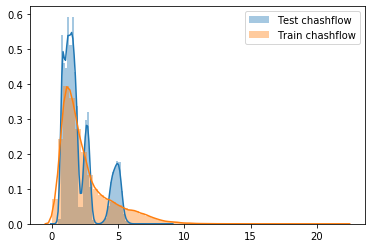

In [6]:
sn.distplot(test_target,label = 'Test chashflow')
sn.distplot(train_target,label = 'Train chashflow')
plt.legend()

In [25]:
model = tf.keras.Sequential([
                    tf.keras.layers.Dense(128, activation='relu',input_shape = [len(train_data.keys())]),
                    tf.keras.layers.Dense(128, activation='relu'),
                    tf.keras.layers.Dense(128, activation='relu',kernel_regularizer=regularizers.l1(0.0001)),
                    tf.keras.layers.Dense(128, activation='relu',kernel_regularizer=regularizers.l1(0.0001)), 
                    tf.keras.layers.Dense(128, activation='relu',kernel_regularizer=regularizers.l1(0.0001)), 
                    tf.keras.layers.Dense(128, activation='relu',kernel_regularizer=regularizers.l1(0.0001)), 
                    #tf.keras.layers.Dense(64, activation='relu'),
                    #tf.keras.layers.Dense(128, activation='relu',kernel_regularizer=tf.keras.regularizers.l1(l=0.00001)),                 
                    #tf.keras.layers.Dense(64, activation='relu',kernel_regularizer=tf.keras.regularizers.l1(l=0.0001)),
                    tf.keras.layers.Dense(1)       
])
model.compile(loss = 'mse',
              optimizer = tf.keras.optimizers.Adagrad(0.001),
              metrics = ['mae','mse'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 128)               7040      
_________________________________________________________________
dense_8 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_9 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_10 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_11 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_12 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_13 (Dense)             (None, 1)                

In [26]:
EPOCHS = 120
history = model.fit(
  train_data, train_target,
  batch_size = 64,
  epochs=EPOCHS, validation_data=(test_data,test_target))

Epoch 1/120
3165/3165 [==============================] - 11s 3ms/step - loss: 0.7555 - mae: 0.2642 - mse: 0.2559 - val_loss: 0.5210 - val_mae: 0.1149 - val_mse: 0.0237
Epoch 2/120
3165/3165 [==============================] - 11s 3ms/step - loss: 0.5412 - mae: 0.1397 - mse: 0.0462 - val_loss: 0.5081 - val_mae: 0.0924 - val_mse: 0.0154
Epoch 3/120
3165/3165 [==============================] - 11s 3ms/step - loss: 0.5242 - mae: 0.1185 - mse: 0.0338 - val_loss: 0.5017 - val_mae: 0.0893 - val_mse: 0.0136
Epoch 4/120
3165/3165 [==============================] - 10s 3ms/step - loss: 0.5135 - mae: 0.1064 - mse: 0.0276 - val_loss: 0.4959 - val_mae: 0.0835 - val_mse: 0.0123
Epoch 5/120
3165/3165 [==============================] - 10s 3ms/step - loss: 0.5052 - mae: 0.0986 - mse: 0.0237 - val_loss: 0.4919 - val_mae: 0.0865 - val_mse: 0.0126
Epoch 6/120
3165/3165 [==============================] - 10s 3ms/step - loss: 0.4982 - mae: 0.0925 - mse: 0.0211 - val_loss: 0.4865 - val_mae: 0.0831 - val_mse:

3165/3165 [==============================] - 11s 3ms/step - loss: 0.3262 - mae: 0.0451 - mse: 0.0050 - val_loss: 0.3262 - val_mae: 0.0609 - val_mse: 0.0064
Epoch 50/120
3165/3165 [==============================] - 11s 3ms/step - loss: 0.3232 - mae: 0.0448 - mse: 0.0049 - val_loss: 0.3252 - val_mae: 0.0680 - val_mse: 0.0084
Epoch 51/120
3165/3165 [==============================] - 11s 3ms/step - loss: 0.3202 - mae: 0.0445 - mse: 0.0049 - val_loss: 0.3223 - val_mae: 0.0678 - val_mse: 0.0084
Epoch 52/120
3165/3165 [==============================] - 11s 3ms/step - loss: 0.3171 - mae: 0.0442 - mse: 0.0048 - val_loss: 0.3192 - val_mae: 0.0674 - val_mse: 0.0083
Epoch 53/120
3165/3165 [==============================] - 10s 3ms/step - loss: 0.3142 - mae: 0.0439 - mse: 0.0047 - val_loss: 0.3161 - val_mae: 0.0666 - val_mse: 0.0081
Epoch 54/120
3165/3165 [==============================] - 11s 3ms/step - loss: 0.3112 - mae: 0.0436 - mse: 0.0047 - val_loss: 0.3125 - val_mae: 0.0636 - val_mse: 0.0073

3165/3165 [==============================] - 49s 16ms/step - loss: 0.2101 - mae: 0.0363 - mse: 0.0032 - val_loss: 0.2126 - val_mae: 0.0607 - val_mse: 0.0066- loss: 0.2103 - ma
Epoch 98/120
3165/3165 [==============================] - 20s 6ms/step - loss: 0.2083 - mae: 0.0362 - mse: 0.0032 - val_loss: 0.2126 - val_mae: 0.0689 - val_mse: 0.0084
Epoch 99/120
3165/3165 [==============================] - 12s 4ms/step - loss: 0.2066 - mae: 0.0360 - mse: 0.0032 - val_loss: 0.2092 - val_mae: 0.0614 - val_mse: 0.0067
Epoch 100/120
3165/3165 [==============================] - 10s 3ms/step - loss: 0.2048 - mae: 0.0360 - mse: 0.0032 - val_loss: 0.2085 - val_mae: 0.0658 - val_mse: 0.0077
Epoch 101/120
3165/3165 [==============================] - 10s 3ms/step - loss: 0.2031 - mae: 0.0359 - mse: 0.0031 - val_loss: 0.2063 - val_mae: 0.0635 - val_mse: 0.0072
Epoch 102/120
3165/3165 [==============================] - 10s 3ms/step - loss: 0.2014 - mae: 0.0357 - mse: 0.0031 - val_loss: 0.2055 - val_mae: 0

In [27]:
y_act = test_target.to_numpy()
y_pred = model.predict(test_data).reshape(-1)

In [36]:
pos = 78324#np.random.randint(0, 99000)
y0 = y_act[np.arange(pos,pos + 3000)]
y1 = y_pred[np.arange(pos, pos + 3000)]
print(pos)
yy0 = VaR(y0)
print(yy0)
yy1 = VaR(y1)
print(VaR(yy1))
print(np.abs(yy1 - yy0))


78324
[0.66359892 0.6946306  0.7273686  0.75268596 0.76765557 0.78305454
 0.80037335 0.81291949 0.82301731 0.83600838]
[0.7213604 0.7213604 0.7213604 0.7213604 0.7406373 0.7406373 0.7406373
 0.7406373 0.7406373 0.7406373]
[0.05776147 0.04600671 0.03198421 0.02310592 0.02807872 0.0258395
 0.02131423 0.02081556 0.02410082 0.02435737]


In [33]:
dff = pd.DataFrame({'Act': test_target, 'Pred' : y_pred})
dff.describe()

,Act,Pred
count,102229.000000,102229.000000
mean,2.119526,2.076722
std,1.353206,1.310628
min,0.322815,0.380432
25%,1.168864,1.146918
50%,1.603277,1.558219
75%,2.647212,2.542322
max,8.725821,8.226402


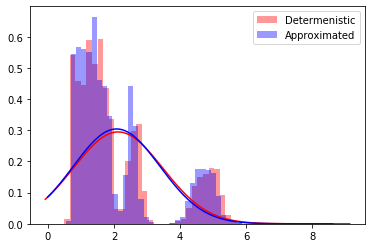

In [34]:
sn.distplot(y_act,fit = stats.norm, color = 'red', label = 'Determenistic',fit_kws={"color":"red"},kde = False)
sn.distplot(y_pred, fit = stats.norm, color = 'blue', label = 'Approximated',fit_kws={"color":"blue"},kde=False)
plt.legend()

In [37]:
version = 1
export_path = os.path.join(modeldir, str(version))
print('export_path = {}\n'.format(export_path))

tf.keras.models.save_model(
    model,
    export_path,
    overwrite=True,
    include_optimizer=True,
    save_format=None,
    signatures=None,
    options=None
)

print('\nSaved model:')

export_path = C:\Users\PLDD\Practice\GitHub\Python\MHS\models\1

INFO:tensorflow:Assets written to: C:\Users\PLDD\Practice\GitHub\Python\MHS\models\1\assets

Saved model:
